In [1]:
import sys
import platform
from os.path import join, exists, abspath, dirname
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
from sklearn.metrics import r2_score
import seaborn as sns

from tqdm import tqdm

In [2]:
import nibabel as nb
from nilearn import plotting, image
from nipype.interfaces import fsl

In [3]:
dir_current = getcwd().replace('\\','/')

tmp = dir_current.split('/')
idx = [ii for ii, s in enumerate(tmp) if s=='github'][0]

dir_git = '/'.join(tmp[:idx+1])
dir_git

'/home/sungbeenpark/github'

In [4]:
dname = join(dir_git,'nitools')
sys.path.append(dname)
import nitools as nt

In [5]:
dname = join(dir_git,'SUITPy')
sys.path.append(dname)
import SUITPy as suit

In [6]:
dname = join(dir_git)
sys.path.append(dname)
import surfAnalysisPy as surf

In [7]:
dname = join(dir_git,'SeqSpatialSupp_fMRI')
sys.path.append(dname)
from SSS import deal_spm
from SSS import util as su
from SSS import plot as splt
from SSS import image as simage

---

In [8]:
list_subj = su.get_list_sn()

In [9]:
list_roi = simage.get_list_roi()
list_param = [[4,14],[5,15],[6,16],[7,17],[8,18],[9,19]]

### check the design matrix and the basis function

In [10]:
dir_root = su.get_dir_root()
dir_root

'/mnt/f/SeqSpatialSupp_fMRI'

In [11]:
subj = 'S01'
glm = 1

dir_glm = su.get_dir_glm(glm)
SPM = join(dir_glm,subj,'SPM.mat')
exists(SPM)
# SPM = deal_spm.load_SPM(SPM)

True

In [12]:
df_onset = deal_spm.get_df_onset(SPM)
df_onset

,run,reg,onset
0,1,"(1,L)","[111.03, 156.03, 176.03, 231.03, 236.03, 316.0..."
1,1,"(1,S)","[26.03, 61.03, 66.03, 76.03, 146.03, 161.03, 2..."
2,1,"(2,L)","[21.03, 31.03, 136.03, 216.03, 271.03000000000..."
3,1,"(2,S)","[6.03, 36.03, 46.03, 56.03, 131.03, 151.03, 24..."
4,1,"(3,L)","[41.03, 81.03, 86.03, 106.03, 116.03, 186.03, ..."
...,...,...,...
59,8,"(2,S)","[11.03, 131.03, 141.03, 166.03, 241.03, 246.03..."
60,8,"(3,L)","[21.03, 36.03, 41.03, 61.03, 146.03, 176.03, 1..."
61,8,"(3,S)","[46.03, 156.03, 161.03, 256.03000000000003, 31..."
62,8,"(4,L)","[16.03, 66.03, 111.03, 226.03, 231.03, 276.030..."


In [13]:
# onsets_by_run = deal_spm.get_concat_onset(SPM)

<Axes: >

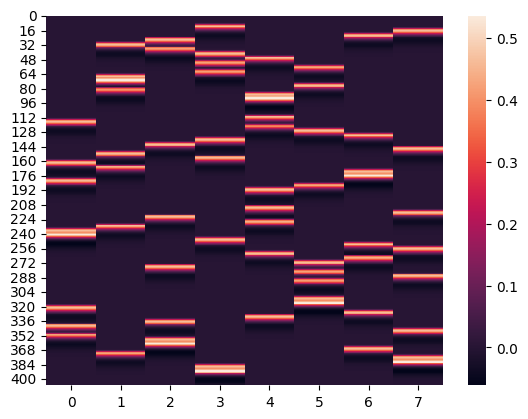

In [14]:
X = deal_spm.get_SPM_X(SPM, run=1)
sns.heatmap(X)

---

## FreeSurfer

Atlas

In [15]:
dir_atlas = su.get_dir_atlas()

In [16]:
dname = join(dir_git,'surfAnalysisPy')
# underlay = su.get_underlay(dname, hemi='L')
border = simage.get_border(dname, hemi='L')

In [17]:
# list_roi = ['SMA', 'PMv', 'PMd', 'M1', 'S1', 'SPLa', 'SPLp', 'DSVC', 'MT+', 'VSVC', 'EAC']
list_roi = simage.get_list_roi()
list_roi

array(['S1', 'M1', 'PMd', 'PMv', 'SMA', 'V1', 'SPLa', 'SPLp'], dtype='<U4')

9 [0 1 2 3 4 5 6 7 8]


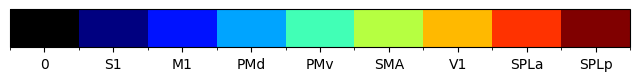

In [18]:
# data = nb.load(join(dir_atlas,'ROI.L.SSS.label.gii'))
data = nb.load(join(dir_atlas,'ROI.32k.L.label.gii'))
tmp = np.unique(data.darrays[0].data)
print(len(tmp), tmp)

cmap = splt.cmap_for_cbar(list_roi, cmap='jet')

<Axes: >

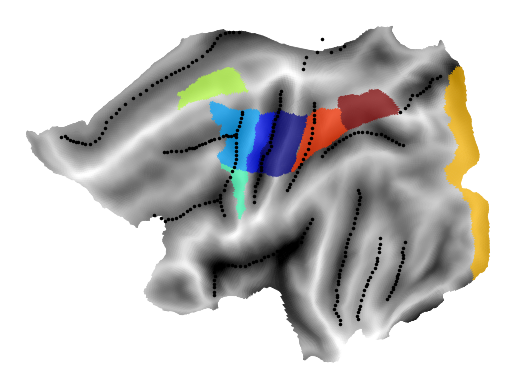

In [19]:
fig, ax = plt.subplots()

plt.sca(ax)
surf.plot.plotmap(
    data=data,
    surf='fs32k_L',
    alpha=0.7, cmap=cmap, colorbar=False,
    borders=border, bordercolor='black', bordersize=3,
    overlay_type='func', render='matplotlib'
)
# fig.savefig(
#     join(dir_result,'fig.ROI.png'),
#     dpi=300, facecolor=[1,1,1,1],
#     bbox_inches='tight'
# )

## Deformated ROIs

In [20]:
dir_roi = su.get_dir_roi()
dir_anat = su.get_dir_anat()

In [21]:
subj = 'S01'
underlay = join(dir_anat,subj,'%s_anatomical.nii'%subj)

In [22]:
img_roi = simage.load_summed_roi(subj, list_roi)

In [23]:
for ii, roi in enumerate(list_roi):
    idx = img_roi.get_fdata()==(ii+1)
    print(roi, idx.sum())

S1 1114
M1 565
PMd 1618
PMv 526
SMA 900
V1 1514
SPLa 1008
SPLp 1203


In [24]:
# plotting.view_img(
#     stat_map_img=img_roi,
#     bg_img=underlay,
#     cmap=cmap, colorbar=False,
#     symmetric_cmap=False, vmin=0, vmax=tmp.max()
# )

In [25]:
del img_roi

In [26]:
# for ss in ['S','R']:
#     subj = ss+nn
    
#     S_id = subj.replace('R','S')
#     underlay = join(dir_anat,S_id,'%s_anatomical.nii'%S_id)
#     img_roi = load_roi(subj,glm)
    
#     fig, ax = plt.subplots()
    
#     g = plotting.plot_roi(
#         roi_img=img_roi,
#         bg_img=underlay,
#         cut_coords=[-30, -72, 54], draw_cross=False,
#         cmap=cmap, colorbar=False,
#         # view_type='contours',
#         black_bg=True,
#         axes=ax
#     )
#     ax.set_title(subj)
    
#     # fig.savefig(
#     #     join(dir_result,'fig.%s.ROI.volume.%s.png'%(glm,subj)),
#     #     dpi=300, facecolor=[1,1,1,1],
#     #     bbox_inches='tight'
#     # )

---

### Extracted $ys$ by Matlab

In [27]:
# def load_ts(subj,glm,dir_work):
#     ## load data
#     matfile = join(dir_work,'%s.glm%d.11rois.mat'%(subj,glm))
#     file = h5py.File(matfile)
#     data = file['Q']
#     D = data['Y']['D']
#     onsets = D['ons'][:].flatten()
#     start_sess = D['start_sess'][:].flatten()

#     ## arrange the data
#     dict_y = {}
#     for ss in ['y_raw','y_adj','y_hat','y_res']:
#         tmp = np.copy(data['Y'][ss][:])
#         dict_y[ss] = tmp
    
#     return dict_y, onsets, start_sess

In [28]:
# def plot_ts(subj, glm, dir_root, list_roi):
#     ## initialize variables
#     list_run = ['r%02d'%(ii+1) for ii in range(8)]
    
#     ## define directories
#     dir_roi = join(dir_root,'ROI')
#     dir_work = join(dir_roi,'glm%d'%glm,subj)
#     dir_result = dir_work

#     ## load time series
#     dict_y, onsets, start_sess = load_ts(subj, glm, dir_work)
    
#     ## plot the figure
#     nrows = 8
#     for ii, roi in enumerate(list_roi):
#         fig, axs = plt.subplots(nrows=nrows, figsize=(30,3*nrows))
#         for rr, run in enumerate(list_run):
#             ax = axs[rr]
#             plt.sca(ax)
        
#             idx_tr = np.arange(410*rr,410*(rr+1))
#             idx_trial = np.arange(68*rr,68*(rr+1))
            
#             df = pd.DataFrame()
#             for ss in ['y_adj','y_hat','y_res']:
#                 df[ss] = dict_y[ss][ii,idx_tr]
            
#             sns.lineplot(data=df, ax=ax)
#             xticks = sorted(onsets[idx_trial]) - start_sess[rr]
#             ax.set_xticks(xticks)
#             xticklabels = ['%d'%(int(t)) for t in xticks]
#             ax.set_xticklabels(xticklabels, rotation=30)
#             ax.grid(axis='both')
#             handles, labels= ax.get_legend_handles_labels()
#             ax.legend(handles=handles, labels=labels, loc='upper left')
#             ax.set_ylabel(run, fontsize=15)
#             ax.set_title('%s (%s)'%(subj,roi), fontsize=15, loc='left')
        
#         fig.savefig(
#             join(dir_result,'fig.ts.%s.%s.png'%(subj,roi)),
#             dpi=300, facecolor=[1,1,1,1],
#             bbox_inches='tight'
#         )
#         plt.close(fig)

In [29]:
# for ss in ['S','R']:
#     for nn in list_nn:
#         subj = ss+nn
#         plot_ts(subj=subj, glm=3, dir_root='/mnt/f/SeqSpatialSupp_fMRI', list_roi=list_roi)

---

### Canonical HRF library

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,1.099000e-04,4.208300e-05,1.413100e-05,2.812500e-07,-1.904500e-05,-0.000065,-0.000134,-0.000444,-2.439000e-07,1.585000e-10,9.777200e-14,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,6.019900e-04,2.836200e-04,1.199800e-04,9.923700e-06,-7.076500e-05,-0.000166,-0.000277,-0.000703,-1.176300e-06,1.769400e-08,9.352000e-10,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,1.567200e-03,8.319600e-04,4.025000e-04,6.053000e-05,-1.372300e-04,-0.000278,-0.000417,-0.000912,-2.383700e-06,2.595400e-07,3.808200e-08,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,3.009000e-03,1.736000e-03,9.232700e-04,2.017500e-04,-1.843600e-04,-0.000377,-0.000541,-0.001081,-1.624000e-06,1.659400e-06,3.862700e-07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,2.154600e-17,5.303800e-18,5.246700e-18,-1.491800e-13,-7.158700e-08,-0.000007,-0.000056,-0.000214,-1.271300e-04,-3.078200e-05,-4.049300e-06,-4.854900e-07,-7.904600e-08,-1.166900e-08,-5.406800e-09,-5.896400e-09,-8.641800e-08,-1.612800e-08,1.030700e-08,5.588100e-08
497,1.976400e-17,4.845200e-18,4.786500e-18,-1.392200e-13,-6.930700e-08,-0.000006,-0.000055,-0.000212,-1.255800e-04,-3.016700e-05,-3.925000e-06,-4.652800e-07,-7.503500e-08,-1.096900e-08,-5.065200e-09,-5.532700e-09,-8.242800e-08,-1.610700e-08,9.947800e-09,5.417900e-08
498,1.812900e-17,4.426200e-18,4.366700e-18,-1.299100e-13,-6.709800e-08,-0.000006,-0.000055,-0.000210,-1.240500e-04,-2.956400e-05,-3.804300e-06,-4.458900e-07,-7.122300e-08,-1.031000e-08,-4.744700e-09,-5.191100e-09,-7.861700e-08,-1.608600e-08,9.601400e-09,5.252800e-08
499,1.662900e-17,4.043300e-18,3.983600e-18,-1.212300e-13,-6.495900e-08,-0.000006,-0.000054,-0.000209,-1.225300e-04,-2.897300e-05,-3.687200e-06,-4.272800e-07,-6.759900e-08,-9.689700e-09,-4.444100e-09,-4.870000e-09,-7.497600e-08,-1.606500e-08,9.267100e-09,5.092700e-08


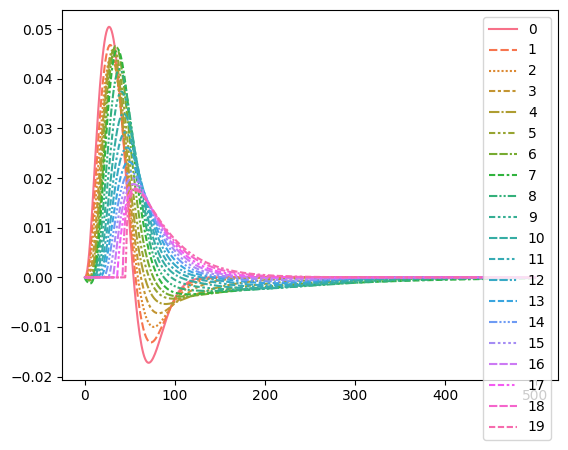

In [30]:
fname = join(su.get_dir_SSS(),'getcanonicalhrflibrary.tsv')
df = pd.read_csv(fname, delimiter='\t', header=None)
sns.lineplot(data=df)
df

In [31]:
df_tmp = df.reset_index().melt(id_vars='index', var_name='No.', value_name='hrf').rename(columns={'index':'x'})
df_tmp

,x,No.,hrf
0,0,0,0.000000e+00
1,1,0,1.099000e-04
2,2,0,6.019900e-04
3,3,0,1.567200e-03
4,4,0,3.009000e-03
...,...,...,...
10015,496,19,5.588100e-08
10016,497,19,5.417900e-08
10017,498,19,5.252800e-08
10018,499,19,5.092700e-08


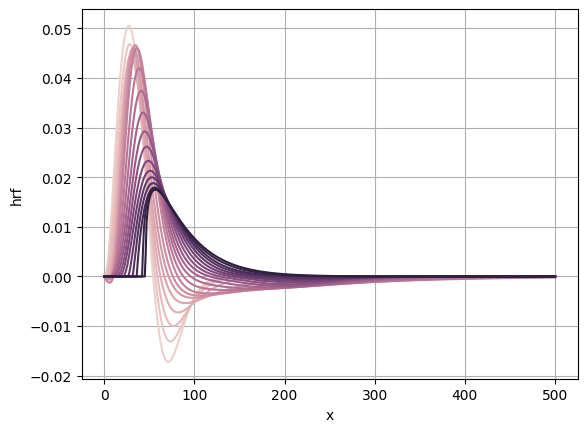

In [32]:
g = sns.lineplot(
    data=df_tmp,
    x='x', y='hrf', hue = 'No.'
)
g.legend().remove()
g.grid(axis='both')

---

### Load HRF from `xBF.mat`

In [33]:
glm = 1
dir_glm = su.get_dir_glm(glm)

#### 1. hrf

In [34]:
subj = 'S01'

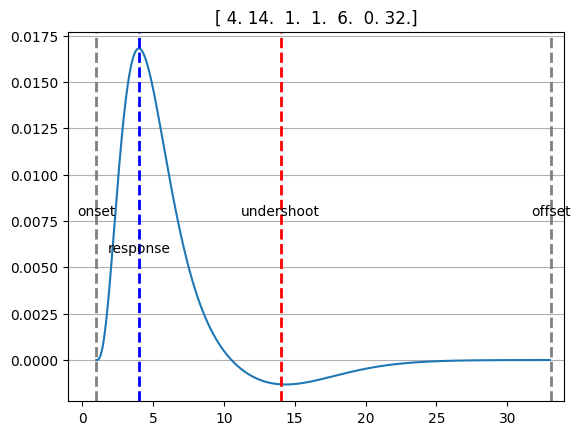

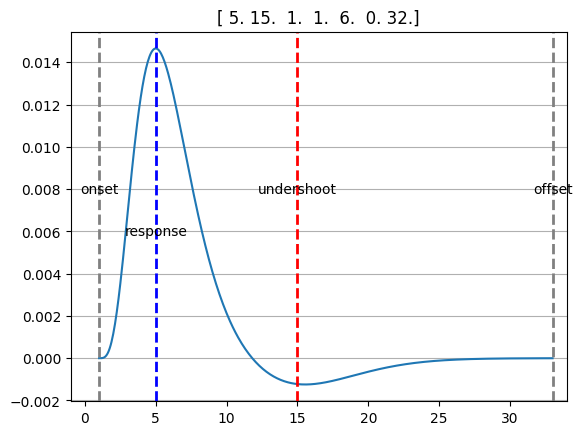

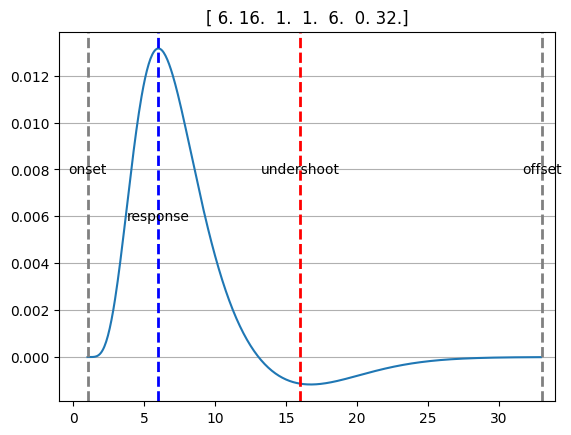

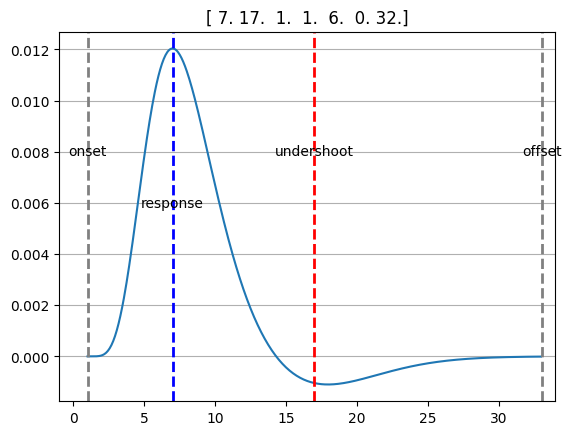

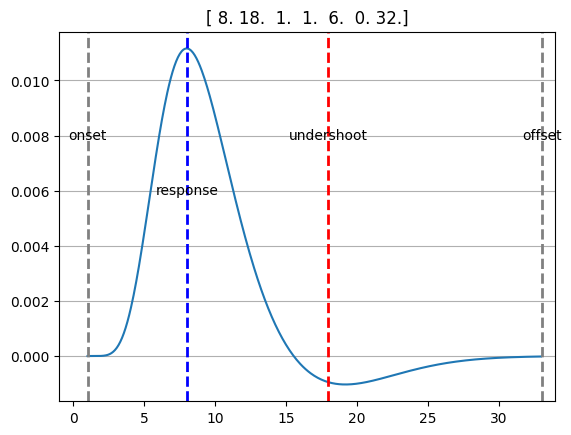

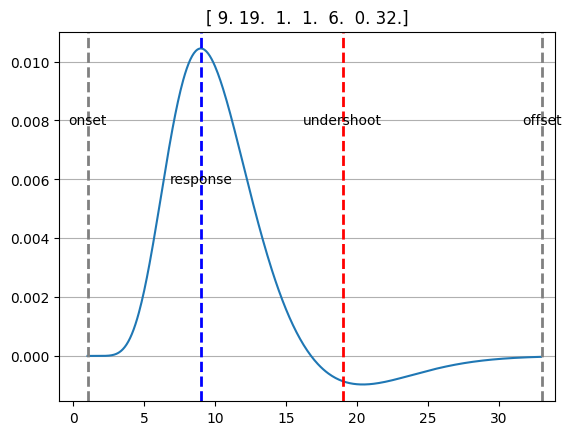

In [35]:
for param in [[4,14],[5,15],[6,16],[7,17],[8,18],[9,19]]:
    fname = join(dir_glm,subj,'hrf_tune/xBF_%s.mat'%su.convert_param_to_hrf(param, type='str'))
    xBF = deal_spm.get_xBF_params(fname)
    splt.plot_BF(xBF)

#### 2. overall response of $X$ by run

In [36]:
subj = 'S01'

In [37]:
SPM = join(dir_glm, subj,'SPM.mat')

df = deal_spm.get_df_X(SPM)
df

,TR,run,X_sum
0,0,1,0.000000
1,1,1,0.000000
2,2,1,0.000000
3,3,1,0.000000
4,4,1,0.000000
...,...,...,...
3251,402,8,-0.058913
3252,403,8,-0.050791
3253,404,8,-0.041897
3254,405,8,-0.033227


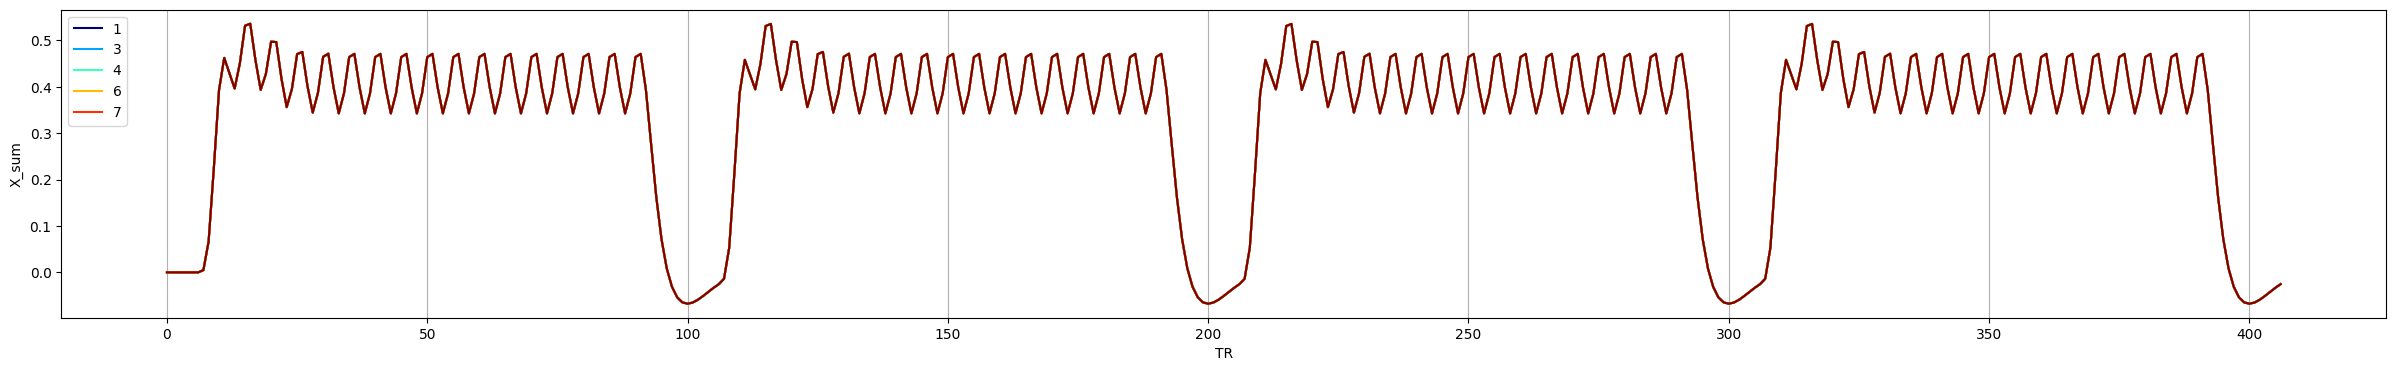

In [38]:
fig, ax = plt.subplots(figsize=(30,4))

g = sns.lineplot(
    data=df,
    x='TR', y='X_sum', hue='run',
    palette=cm.jet.resampled(8),
    ax=ax
)
g.grid(axis='x')
g.legend(loc='upper left')

In [39]:
del SPM, df

#### 3. overall response of $y$ by run

In [8]:
glm = 1
dir_glm = su.get_dir_glm(glm)

In [9]:
dir_result = su.get_dir_result()
dir_work = join(dir_result,'mean_y_across_run')
makedirs(dir_work, exist_ok=True)

In [ ]:
nrows, ncols = 6, 1

for ss in ['S','R']:
    for nn in su.get_list_sn():
        subj = ss+nn
        SPM = join(dir_glm,subj,'SPM.mat')
        df_onset = deal_spm.get_df_onset(SPM)
        onsets_by_run = []
        for rr in range(8):
            run = rr+1
            onsets_by_run.append(
                np.sort(
                    np.concatenate(df_onset[df_onset.run==run].onset.values)
                ).astype(int)
            )
        for roi in simage.get_list_roi():
            fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(30*ncols,4*nrows))
            plt.close()
            for ii, param in enumerate([[4,14],[5,15],[6,16],[7,17],[8,18],[9,19]]):
                ax = axs[ii]
                df_y = simage.get_df_y(subj=subj,glm=glm,roi=roi,param=param,hemi='L',show_yraw=False,melt=True)
                g = sns.lineplot(
                    data=df_y[df_y.hue!='y_res'],
                    x='TR', y='y', hue='hue',
                    ax=ax
                )
                handles, labels = g.get_legend_handles_labels()
                g.legend(handles, [r'$%s_{%s}$'%(s.split('_')[0],s.split('_')[1]) for s in labels], loc='upper left', fontsize=12)
                g.grid(axis='x', linestyle='--', color='gray')
                g.set_ylabel(r'mean $y$ across run', fontsize=16)
                g.set_xlabel('TR', fontsize=16)
                xticks = g.get_xticks()[1:-1]
                g.set_xticks(xticks)
                g.set_xticklabels(['%d'%x for x in xticks], fontsize=14)
                yticks = g.get_yticks()[1:-1]
                g.set_yticks(yticks)
                g.set_yticklabels(['%.2f'%y for y in yticks], fontsize=14)
                g.set_title('%s (%s, %s)'%(su.convert_param_to_hrf(params=param,type='str'), subj, roi))

                for onset in onsets_by_run[ii]:
                    g.axvline(x=onset, color='red', linestyle='--')

            fig.tight_layout()
            # plt.show()
            fig.savefig(
                join(dir_work,'y_mean.%s.%s.png'%(subj,roi)),
                dpi=300, facecolor=[1,1,1,1],
                bbox_inches='tight'
            )

#### 4. Time series time lock to stimulus onset

In [8]:
glm = 1
dir_glm = su.get_dir_glm(glm)

In [9]:
dir_result = su.get_dir_result()
dir_work = join(dir_result,'y_window')
makedirs(dir_work, exist_ok=True)

i) normal trials

In [18]:
nrows, ncols = 4, 2

for ss in ['S','R']:
    for nn in su.get_list_sn():
        subj = ss+nn
        for roi in simage.get_list_roi():
            for param in [[4,14],[5,15],[6,16],[7,17],[8,18],[9,19]]:
                df_window_y = simage.get_df_window_y(subj=subj,glm=glm,roi=roi,param=param)

                fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols,4*nrows))
                axs = np.concatenate(axs)
                plt.close()
                for rr in range(8):
                    ax = axs[rr]
                    run = rr+1
                    g = sns.lineplot(
                        data=df_window_y[df_window_y.run==run],
                        x='TR', y='y', hue='hue',
                        ax=ax
                    )
                    handles, labels = g.get_legend_handles_labels()
                    g.legend(handles, [r'$%s_{%s}$'%(s.split('_')[0],s.split('_')[1]) for s in labels], loc='upper left', fontsize=12)
                    g.grid(axis='x', linestyle='--', color='gray')
                    g.set_ylabel(r'mean $y$ across window', fontsize=16)
                    g.set_xlabel('TR', fontsize=16)
                    xticks = g.get_xticks()[1:-1]
                    g.set_xticks(xticks)
                    g.set_xticklabels(['%d'%x for x in xticks], fontsize=14)
                    yticks = g.get_yticks()[1:-1]
                    g.set_yticks(yticks)
                    g.set_yticklabels(['%.2f'%y for y in yticks], fontsize=14)
                    g.set_title('run%02d (%s, %s, %s)'%(run, subj, roi, str(param)))
                    g.axvline(x=0, color='red', linestyle='-')

                fig.tight_layout()
                # plt.show()
                fig.savefig(
                    join(dir_work,'y_window.%s.%s.%s.png'%(subj,roi,su.convert_param_to_hrf(params=param,type='str'))),
                    dpi=300, facecolor=[1,1,1,1],
                    bbox_inches='tight'
                )

ii) gap trials

In [14]:
pre, post = 5, 25

In [21]:
list_param = [
    [4,13], [4,14], [4,15],
    [5,14], [5,15], [5,16],
    [6,15], [6,16], [6,17],
]
list_roi = simage.get_list_roi()

In [24]:
nrows, ncols = 3,3
for subj in list_subj:
    for roi in list_roi:
        fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4*nrows))
        axs = np.concatenate(axs)
        for ii, param in enumerate(list_param):
            df_window_y = simage.get_df_window_y(
                subj=subj,
                glm=glm,
                roi=roi,
                param=param,
                pre=pre,post=post,
                gap=16
            )
            ax = axs[ii]
            plt.sca(ax)
            g = sns.lineplot(
                data=df_window_y,
                x='TR', y='y', hue='hue',
                ax=ax
            )
            g.grid(axis='x',linestyle='-')
            g.legend()
            xticks = np.arange(-pre,post+.1,5).astype(int)
            g.set_xticks(xticks)
            g.set_xticklabels(['%d'%x for x in xticks], fontsize=10)
            g.set_xlabel(g.get_xlabel(), fontsize=12)
            g.set_ylabel(r'mean $Y$ across run', fontsize=12)
            g.set_title(su.convert_param_to_hrf(param), fontsize=12)
            g.set_title(su.convert_param_to_hrf(param), fontsize=12)
            for t in [-5,0,20,25]:
                g.axvline(x=t, color='r', linestyle='--')
            plt.close()

        fig.suptitle(roi, fontsize=16)
        fig.tight_layout()
        fig.savefig(
            join(dir_work,'y_window.%s.%s.gap_trial.png'%(subj, roi)),
            dpi=300, facecolor=[1,1,1,1],
            bbox_inches='tight'
        )

---

## Load $\beta$

In [ ]:
subj = 'R01'
glm = 3
param = [6,16]
roi = 'M1'

In [ ]:
beta = simage.load_hrf_tune(subj=subj,glm=glm,roi=roi,param=param,map_='beta')
beta

In [ ]:
dir_glm = su.get_dir_glm(glm)
SPM = join(dir_glm,subj,'SPM.mat')
deal_spm.get_df_vec(SPM)

In [ ]:
fig, ax = plt.subplots()

## (# interest, # voxels)
print(beta.shape)
sns.heatmap(beta.get_fdata(),ax=ax)
plt.show()

---

In [ ]:
# %whos